In [ ]:
# default_exp funcs.dataset

In [ ]:
%load_ext autoreload
%autoreload 2

# Dataset and transformations

In [ ]:
#export
from decode_fish.imports import *
from typing import Union
import skimage.measure
from torch.utils.data import DataLoader
import random
import inspect
from scipy.ndimage import gaussian_filter
from decode_fish.funcs.utils import *
from perlin_numpy import generate_fractal_noise_3d, generate_perlin_noise_3d
from torch.nn import functional as F
import numbers

In [ ]:
#export
class DecodeDataset:

    def __init__(self, volumes: list,
                 dataset_tfms: list, 
                 rate_tfms: list, 
                 bg_tfms: list, 
                 num_iter: int = 5000, 
                 device: str = 'cpu'):
        """
        Basic Dataset

        Args:
            path (str): [image_path]
            dataset_tfms (list): transformation specific to dataset
            rate_tfms ([type]): transformation for rate generation
            bg_transform ([type]): background transformation
            num_iter (int, optional):define lenth of dataset. Defaults to 5000.
            device (str, optional): device cpu or gpu]. Defaults to 'cpu'.
        """
        
        self.volumes = volumes
        self.dataset_tfms = dataset_tfms
        self.num_iter = num_iter
        self.rate_tfms = rate_tfms
        self.bg_tfms = bg_tfms
        self.device = device
        
        print(f'{len(self.volumes)} volumes')
        
    def __len__(self):
        return self.num_iter

    def __getitem__(self, _):
        i = random.randint(0,len(self.volumes)-1)
        x = self.volumes[i] # Adding dimension here to get to 4.
        x = self._compose(x, self.dataset_tfms, ind = i).to(self.device)
        local_rate = self._compose(x, self.rate_tfms, ind = i)
        background = self._compose(x, self.bg_tfms)
        return x, local_rate, background
#         return x.to(self.device), local_rate.to(self.device), background.to(self.device)
    
    def __repr__(self):
        print (f'{self.__class__.__name__} Summary:')
        print (f'Dataset tfms: {len(self.dataset_tfms)}')
        for i in self.dataset_tfms:
            print (f'\n-->')
            f"{i}"
        return ''
    
    @staticmethod
    def _compose(x, list_func, **kwargs):
        if not list_func: list_func.append(lambda x: x)
        for func in list_func:
            x = func(x, **kwargs)
        return x

In [ ]:
#export
def print_class_signature(self, nms):
    "print class signature"
    mod = inspect.currentframe().f_back.f_locals
    for n in nms:
        print(f'{n}: {getattr(self,n)}')
#export
class TransformBase:
    '''
    All transformations optionally must be inherited from this class for nice
    representations and checks if input to given transformations is a tensor

    '''
    def __repr__(self):
        print (f'Transform({self.__class__.__name__})')
        name = inspect.signature(self.__class__).parameters.keys()
        print_class_signature(self, name)
        return ''

    def __call__(self, x, **kwargs):
        assert isinstance(x, torch.Tensor), f'must be torch.tensor not {type(x)}'

    @staticmethod
    def _get_device(x):
        return getattr(x, 'device')

In [ ]:
#export
class ScaleTensor(TransformBase):
    """
    \nScales given `torch.Tensor` between `low` and `high`

    \nParameters:
    \n`low`     : lower bound
    \n`high`    : upper bound
    \n`data_min`: max value of data
    \n`data_max`: min value of main data

    \nReturns:
    \nScaled tensor

    """
    def __init__(self, low: float=0., high: float=1.):
        self.low = low
        self.high = high

    def __call__(self, x, **kwargs) -> torch.Tensor:
        super().__call__(x)
        ratio = (self.high-self.low) / (x.max()-x.min() + 1)
        return ratio * (x - x.min() + 1) + self.low
    
class ShuffleChannel(TransformBase):

    def __call__(self, x, **kwargs) -> torch.Tensor:
        super().__call__(x)

        return x[torch.randperm(len(x))]
    
class RandScale(TransformBase):

    def __init__(self, low: float, high: float):
        self.low = low
        self.high = high

    def __call__(self, x, **kwargs) -> torch.Tensor:
        super().__call__(x)
        ratio = torch.distributions.Uniform(self.low, self.high).sample()
        return ratio * x
    
class UniformValue(TransformBase):
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val
    
    def __call__(self, image, **kwargs):
        rand_val = torch.distributions.Uniform(self.min_val, self.max_val).sample([1]).to(image.device)
        return torch.ones_like(image[:1])*rand_val
    
def get_forward_scaling(img):
    
    offset = np.median(img)
    scale = np.max(np.array(img))/3
    return offset, scale

In [ ]:
#export
class RandomCrop3D(TransformBase):
    """
    Ramdomly Crops 3D tensor.

    \nThis class will generate random crop of `crop_sz`. This class is initialized
    with `img_sz` which should be a demension of 4 [Channel, Height, Width, Depth] and
    a `crop_sz` dimesnion of 3 [Height, Width, Depth] of desired crop. For each crop
    dimension `_get_slice` function will calculate random int ranging from 0 to (img_sz-crop_sz).
    and return tuple of containing two slice intergers. If one dimension of `img_sz` matches
    one dimension of `crop_sz` the resulting tuple will be `(None, None)` which will result
    in not croping this particular dimension.


    \nParameters:
    \n`crop_sz`    : Size of the 3D crop  `(H, W, D)`

    \nReturns:
    \nCroped 3D image of the given `crop_sz`

    """
    def __init__(self, crop_sz, roi_masks):
        assert len(crop_sz) == 3 , f'Lenth of crop_sz should be 3 not {len(crop_sz)}'
        self.crop_sz = tuple(crop_sz)
        self.crop_prod = crop_sz[0]*crop_sz[1]*crop_sz[2]
        self.roi_masks = roi_masks

    def __call__(self, x, **kwargs):
        ch, h, w, d = x.shape
        img_sz  = tuple((h, w, d))
        assert (img_sz) >  self.crop_sz
        super().__call__(x, **kwargs)
        slice_hwd = [self._get_slice(i, k) for i, k in zip(img_sz, self.crop_sz)]
        if 'ind' in kwargs:
            while self._crop(self.roi_masks[kwargs['ind']][None], *slice_hwd).sum()/self.crop_prod < 0.5:
                slice_hwd = [self._get_slice(i, k) for i, k in zip(img_sz, self.crop_sz)]
        return self._crop(x, *slice_hwd)


    @staticmethod
    def _get_slice(sz, crop_sz):
        up_bound = sz-crop_sz
        if  up_bound == 0:
            return None, None
        else:
            l_bound = torch.randint(up_bound, (1,))
        return l_bound, l_bound + crop_sz

    @staticmethod
    def _crop(x, slice_h, slice_w, slice_d):
        return x[:, slice_h[0]:slice_h[1], slice_w[0]:slice_w[1], slice_d[0]:slice_d[1]]

In [ ]:
#export
class AddFoci(TransformBase):
    
    def __init__(self, n_foci_avg: float, rad_range: tuple, n_mol_range: tuple, px_size_zyx: tuple=(100,100,100), mode='gaussian'):
        
        self.n_foci_avg = n_foci_avg
        self.rad_range = rad_range
        self.n_mol_range = n_mol_range
        self.px_size_zyx = px_size_zyx
        self.mode = mode
        
    def binary_sphere(self, shape, radius, position):
        grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
        position = np.ogrid[grid]
        arr = np.zeros(shape, dtype=float)
        for x_i, semisize in zip(position, radius):
            arr += (x_i / semisize) ** 2

        return arr <= 1.0
    
    def gaussian_sphere(self, shape, radius, position):
        grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
        position = np.ogrid[grid]
        arr = np.exp(-position[0]**2 / (2 * (radius[0] ** 2))) * np.exp(-position[1]**2 / (2 * (radius[1] ** 2))) * np.exp(-position[2]**2 / (2 * (radius[2] ** 2))) / (2 * np.pi * (radius[0] * radius[1] * radius[2]))
        return arr
    
    def __call__(self, x, **kwargs) -> torch.Tensor:
        super().__call__(x)
        
        prob = self.n_foci_avg/torch.numel(x[0])
        locations = torch.distributions.Bernoulli(torch.ones_like(x)*prob).sample()
        xwf = x + 0
        
        for inds in torch.nonzero(locations, as_tuple=False):
            rad = torch.distributions.Uniform(*self.rad_range).sample().item()
            rads = [rad/pxs for pxs in self.px_size_zyx]
            n_mol = torch.distributions.Uniform(*self.n_mol_range).sample().item()
            center = inds[-3:].cpu().numpy()
            size = list(x.shape[-3:])
            if 'gaus' in self.mode:
                foci = torch.tensor(self.gaussian_sphere(list(x.shape[-3:]), rads, center))
            if 'bin' in self.mode:
                foci = torch.tensor(self.binary_sphere(list(x.shape[-3:]), rads, center))
            foci = foci * (n_mol / foci.sum())
            xwf[inds[0]] += foci.to(x.device)
        
        return xwf

In [ ]:
# export
class torch_gaussian_filter(torch.nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self,  kernel_size, sigma, dim=2):
        super(torch_gaussian_filter, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        self.kernel_size = kernel_size
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(1, *[1] * (kernel.dim() - 1))

        self.conv = torch.nn.Conv3d(1, 1, kernel_size=kernel_size, padding=[k//2 for k in kernel_size], padding_mode='replicate', bias=0)
        self.conv.weight = torch.nn.Parameter(kernel)

    def forward(self, x):
        """
        Apply gaussian filter to input.
        Arguments:
            x (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        with torch.no_grad():
            shape = x.shape
            out = self.conv(x.reshape(-1,1,*shape[-3:])).reshape(shape)
        return out

In [ ]:
# export
def get_uneven(x):
    return int(2*np.ceil(x/2)-1)

class GaussianSmoothing(TransformBase):
    def __init__(self, smoothing_filter_size, div_factor=1, device='cuda', z_size=48):
        self.smoothing_filter_size = smoothing_filter_size
        self.div_factor = div_factor
        self.gaussian_filter = torch_gaussian_filter(kernel_size=[get_uneven(np.min([z_size, smoothing_filter_size])), 
                                                                  smoothing_filter_size*2-1, 
                                                                  smoothing_filter_size*2-1], 
                                                     sigma=smoothing_filter_size, dim=3).to(device)
    
    def __call__(self, image, **kwargs):
        background = self.gaussian_filter(image[None])/self.div_factor
        # Scipy version, to slow
        # background = gaussian_filter(image, self.smoothing_filter_size)/self.div_factor  
        # background.clamp_min_(1.)
        return background[0]
    
class AddPerlinNoise(TransformBase):
    def __init__(self, shape, res, octaves, scale=1, persistence=0.5, lacunarity=2):
        self.shape = shape
        self.res = res
        self.scale = scale
        self.octaves = octaves
        self.persistence = persistence
        self.lacunarity = lacunarity
    
    def __call__(self, image, **kwargs):
        
        assert all(i <= self.shape for i in image.shape[-3:])
        shape = [self.shape,self.shape,self.shape]
        res = self.res
        if image.shape[-3] == 1:
            shape[0] = 4
            res[0] = 1
            
        bs = len(image)
        fractal_noise = [generate_fractal_noise_3d_torch(shape=shape, 
                                                  res=res, octaves=self.octaves, persistence=self.persistence, device=image.device) for _ in range(bs)]
        fractal_noise = torch.stack(fractal_noise)
        fractal_noise = fractal_noise[:,:image.shape[-3],:image.shape[-2],:image.shape[-1]]
        return image + self.scale*fractal_noise
        

In [ ]:
# noise = generate_fractal_noise_3d(
#     (48, 48, 48), (4, 8, 8), 2, tileable=(False, False, False)
# )

In [ ]:
#export
def get_roi_mask(img, pool_size=(10,10,10), percentile=50):
    img = img.mean(0)
    mp_img = skimage.measure.block_reduce(img, pool_size, np.max)
    thresh = np.percentile(mp_img,percentile)
    mp_img = np.where(mp_img>thresh,1,0)
    mp_img = np.kron(mp_img, np.ones((pool_size), dtype=mp_img.dtype))
    mp_img = mp_img[:img.shape[0], :img.shape[1], :img.shape[2]] 
    return mp_img

In [ ]:
from decode_fish.funcs.file_io import load_psf_noise_micro
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.plotting import *

In [ ]:
pfile = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_1/mRNAlevel_500/random/NR/w1_HelaKyoto_Gapdh_2597_p01_cy3__Cell_CP_10__random__1.tif'
pdir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_1/mRNAlevel_500/random/NR/w1*.tif'
pdir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1/mRNAlevel_500/foci/strong/w1*.tif'
pdir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled/img_stack.tiff'

In [ ]:
imgs_3d        = [load_tiff_image(f) for f in glob.glob(pdir)]
smoothing      = GaussianSmoothing(smoothing_filter_size=5, div_factor=1, z_size=33)
roi_masks      = [get_roi_mask(img, pool_size=(10,10,10), percentile=70) for img in imgs_3d]
rand_crop      = RandomCrop3D((1,48,48), roi_masks)
shuffle_ch     = ShuffleChannel()

In [ ]:
probmap_generator = UniformValue(0.0001, 0.0005)

focifier = AddFoci(n_foci_avg=5, 
                   rad_range=(100,500), 
                   n_mol_range=(5.,30.), 
                   px_size_zyx =(100,100,100),
                   mode='bin')

fractal_noise = AddPerlinNoise(48, [3,6,6], 3, scale=100)

In [ ]:
ds = DecodeDataset(volumes = imgs_3d,
                   dataset_tfms =  [shuffle_ch, rand_crop], 
                   rate_tfms = [probmap_generator, focifier], 
                   bg_tfms = [smoothing],#,fractal_noise], 
                   device='cuda:0', 
                   num_iter=100 * 4) 

1 volumes


In [ ]:
decode_dl = DataLoader(ds, batch_size=10, num_workers=0)

In [ ]:
for i in range(5):
    x, local_rate, background = next(iter(decode_dl))
#     print(x.mean())

In [ ]:
# plot_3d_projections(generate_fractal_noise_3d(shape=(48,48,48), res=(3,6,6), octaves=3, tileable=(False, False, False), persistence=.75, lacunarity=2))

In [ ]:
background.shape

torch.Size([10, 16, 1, 48, 48])

(<Figure size 484.2x441 with 6 Axes>,
 [<AxesSubplot:ylabel='y'>,
  <AxesSubplot:xlabel='x', ylabel='z'>,
  <AxesSubplot:xlabel='z'>])

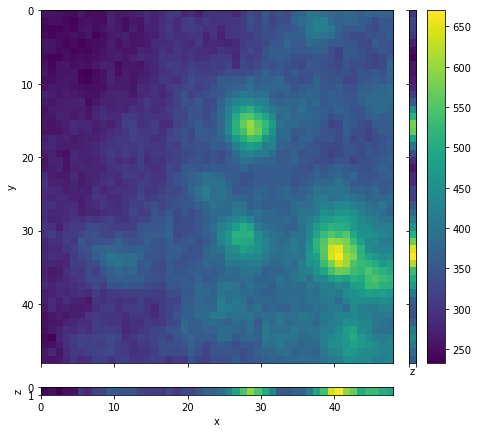

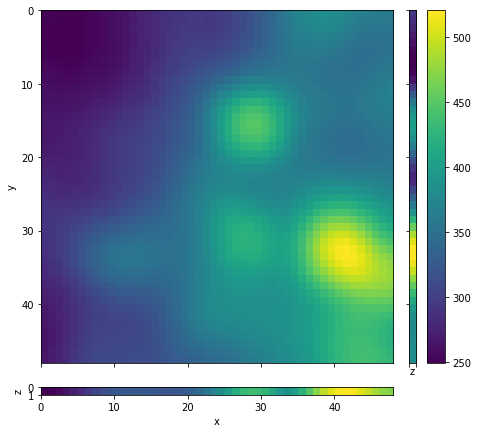

In [ ]:
# x, local_rate, background = next(iter(decode_dl))
plot_3d_projections(x[0,5], proj_func=np.max)
plot_3d_projections(background[0,5], proj_func=np.max)
# plot_3d_projections(x[0,0])

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted index.ipynb.
